# Notes taken reading "Hands on ML with Scikit-Learn Keras & TensorFlow"

***

## Chapter 2. End-to-End Machine Learning Project

***

### Introduction

Goal : predict the median housing price in all districts given all other metrics.

Since we deal with a regression task a common measure of performance is the Root Mean Square Error (RMSE).

$ RMSE(X, h) = \sqrt{ \dfrac{1}{m} \sum\limits_{i=1}^{m} \Big[ h(x^{(i)}) - y^{(i)} \Big]^2 } $

where :

- $m$ is the number of instances in the data set;

- $x^{(i)}$ is the vector of all the feature values excluding the label of the i-th istance in the data set;

- $y^{(i)}$ is the label;

- $X$ is a matrix containing all the feature values of all instances in the data set;

- $h$ is the prediction function, also called hypothesis;

- $RMSE(X, h)$ is the cost function measured on the set of examples using the hypothesis $h$.

***

### Getting the data

In [1]:
pwd()

'/Users/biagiozaffora/Documents/git_repo/Data_science'

In [2]:
# Download the data
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "http://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_PATH
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [3]:
# Load the data
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
# Get dat type and counts (also show null values)
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
# Show categories of "object" type
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [6]:
# Summary of numerical data
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


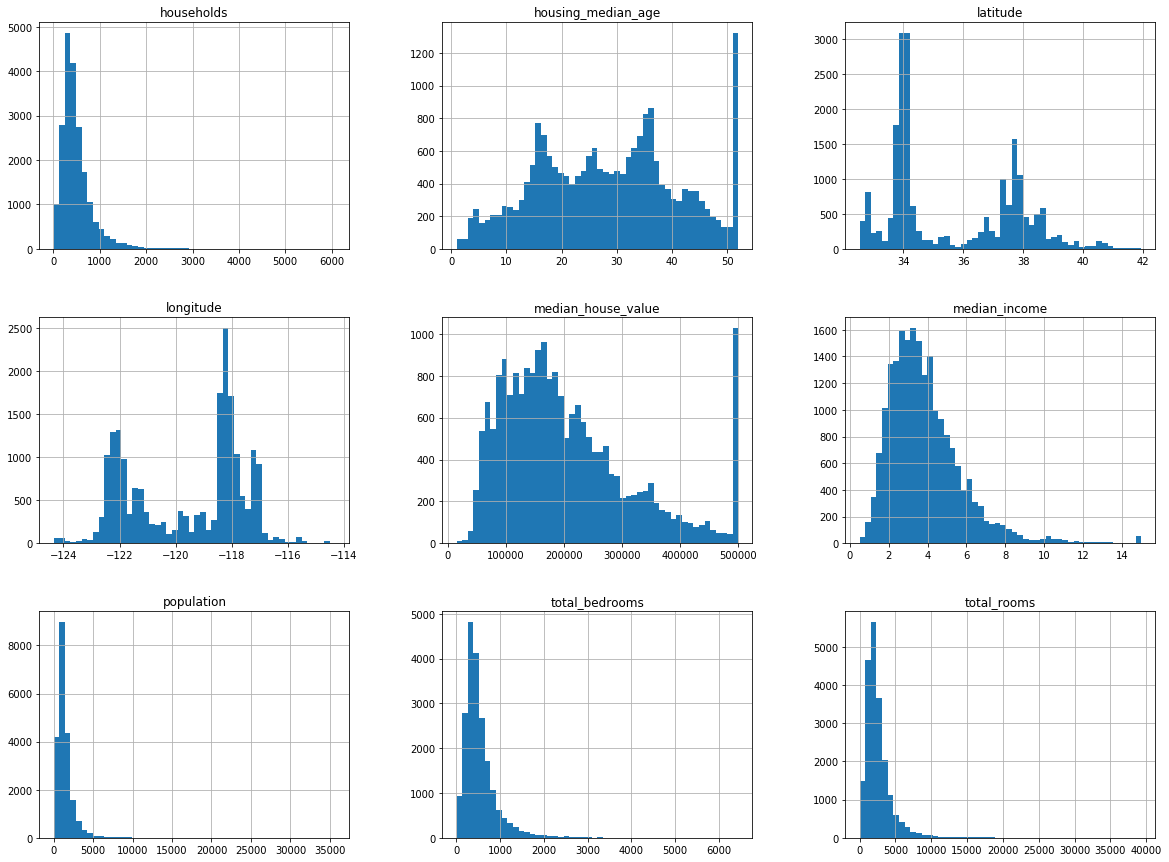

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20, 15))
plt.show()

***

### Create a test set

In [8]:
import numpy as np

def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

#train_set, test_set = split_train_test(housing, 0.2)
#print(len(train_set))
#print(len(test_set))

In [9]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

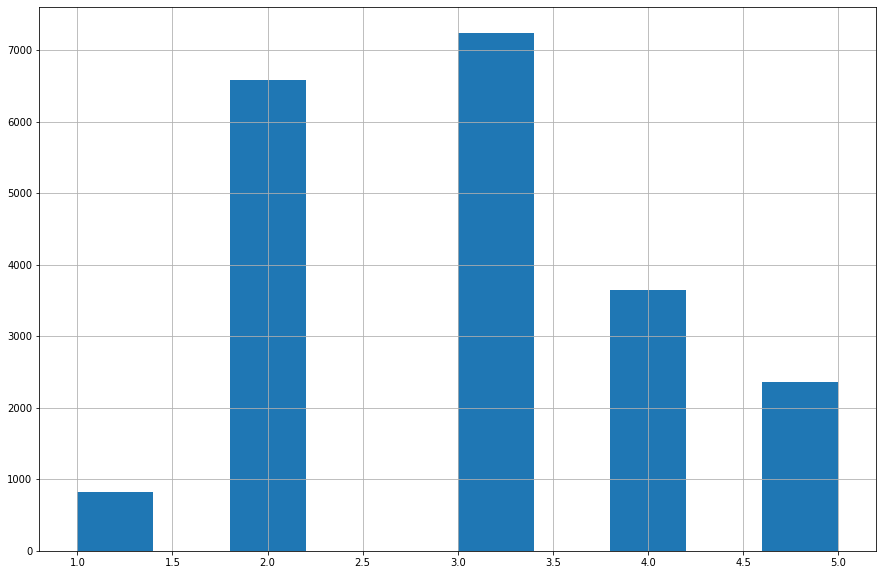

In [10]:
housing['income_cat'] = pd.cut(housing['median_income'],
                              bins=[0., 1.5, 3.0, 4.5, 6.0, np.inf],
                              labels=[1, 2, 3, 4, 5])
housing['income_cat'].hist(figsize=(15, 10))
plt.show()

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [12]:
strat_test_set['income_cat'].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

***
### Discover and Visualize the data to gain insights



In [14]:
housing = strat_train_set.copy()

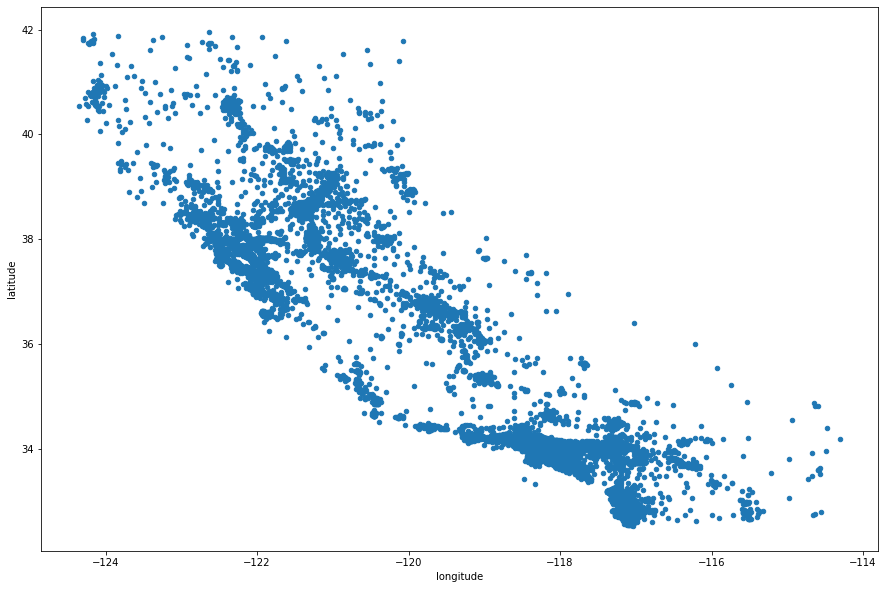

In [15]:
housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(15, 10))
plt.show()

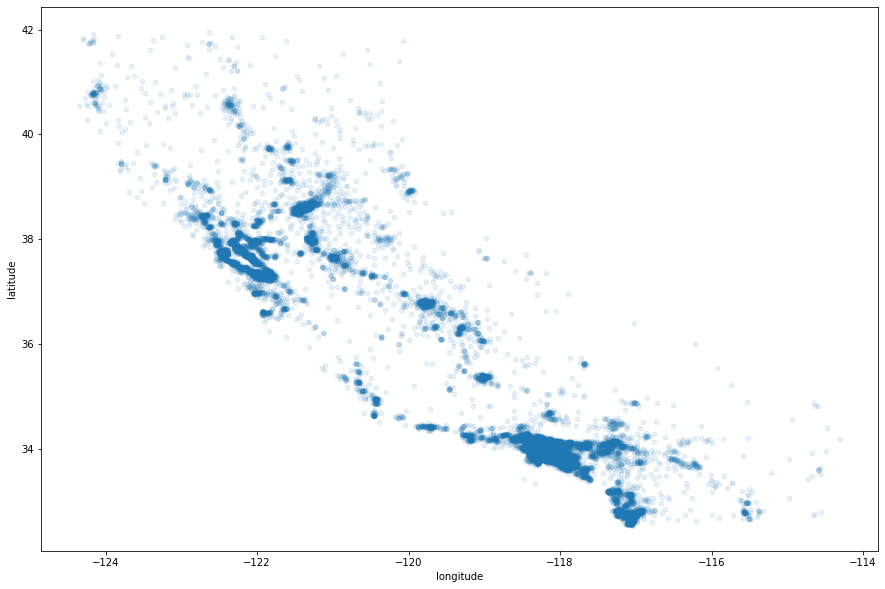

In [16]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1,
            figsize=(15, 10))
plt.show()

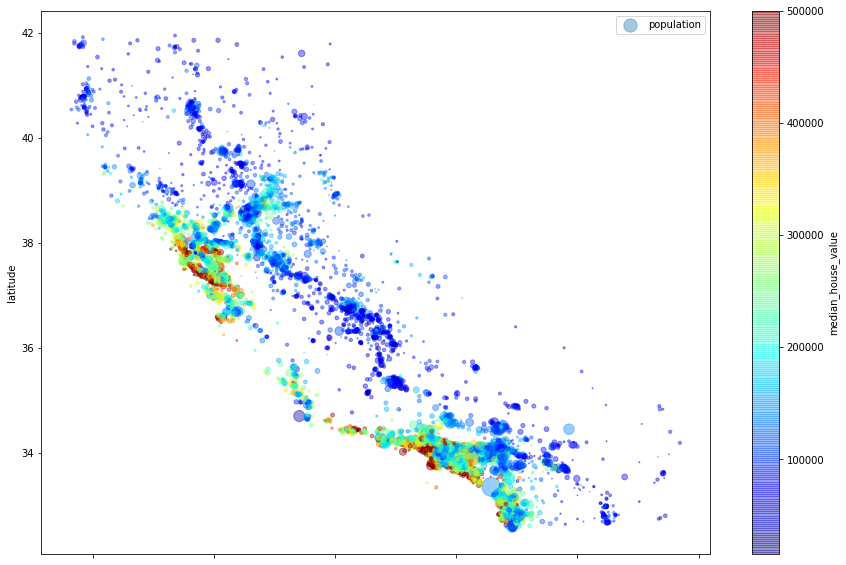

In [17]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
            s=housing['population']/100, label='population', figsize=(15,10),
            c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend()
plt.show()

***
### Looking for correlations

In [19]:
corr_matrix = housing.corr()
corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


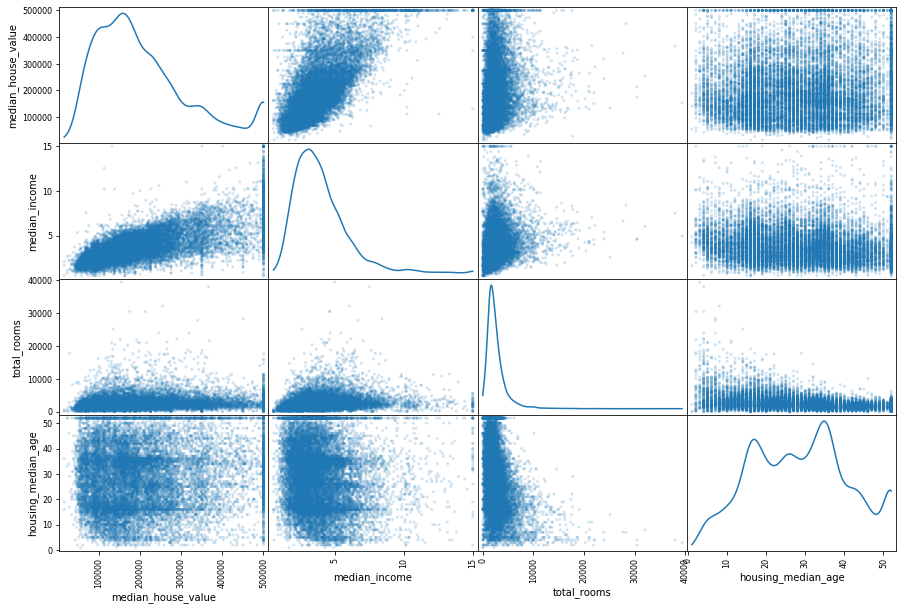

In [24]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], diagonal='kde', alpha=0.2, figsize=(15, 10))
plt.show()

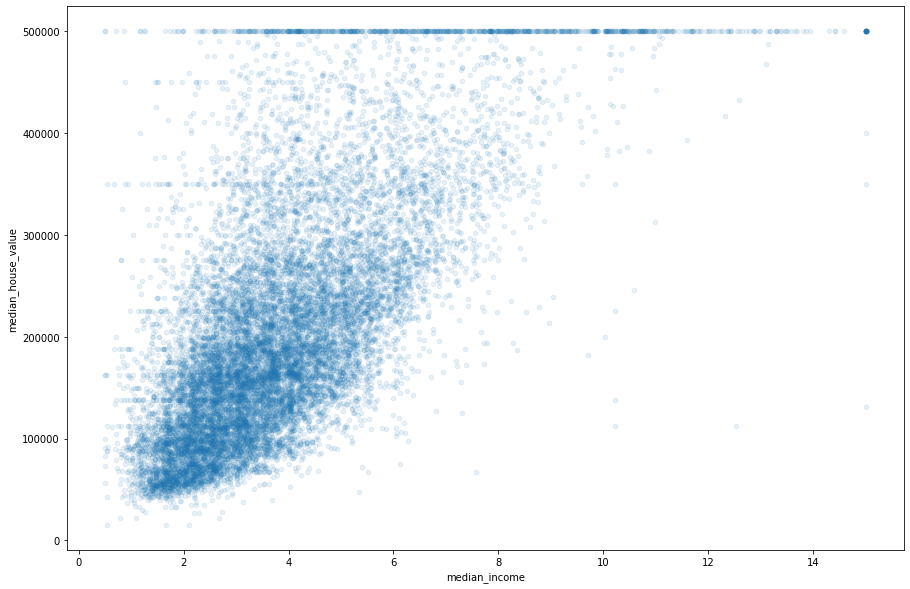

In [25]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1, figsize=(15, 10))
plt.show()

***
### Experimenting with attribute combinations

In [26]:
housing['rooms_per_household'] = housing['total_rooms'] / housing['households']
housing['bedrooms_per_room'] = housing['total_bedrooms'] / housing['total_rooms']
housing['population_per_household'] = housing['population'] / housing['households']

corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

***
### Prepare the data for machine learning algorithms

In [29]:
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

***
### Data cleaning

Multiple options to deal with missing values :

- `dropna()`

- `drop`

- `fillna()`

In [30]:
#housing.dropna(subset=['total_bedrooms'])   # delete districts with NAs
#housing.drop('total_bedrooms', axis=1)      # delete the entire attribute
median = housing['total_bedrooms'].median() # set the NAs to median
housing['total_bedrooms'].fillna(median, inplace=True)

Imputation using `Scikit-learn`

In [32]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')

housing_num = housing.drop('ocean_proximity', axis = 1)
imputer.fit(housing_num)

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='median', verbose=0)

In [33]:
imputer.statistics_
housing_num.median()

longitude             -118.5100
latitude                34.2600
housing_median_age      29.0000
total_rooms           2119.5000
total_bedrooms         433.0000
population            1164.0000
households             408.0000
median_income            3.5409
dtype: float64

In [35]:
X = imputer.transform(housing_num)
X

array([[-121.89  ,   37.29  ,   38.    , ...,  710.    ,  339.    ,
           2.7042],
       [-121.93  ,   37.05  ,   14.    , ...,  306.    ,  113.    ,
           6.4214],
       [-117.2   ,   32.77  ,   31.    , ...,  936.    ,  462.    ,
           2.8621],
       ...,
       [-116.4   ,   34.09  ,    9.    , ..., 2098.    ,  765.    ,
           3.2723],
       [-118.01  ,   33.82  ,   31.    , ..., 1356.    ,  356.    ,
           4.0625],
       [-122.45  ,   37.77  ,   52.    , ..., 1269.    ,  639.    ,
           3.575 ]])

In [36]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                         index=housing_num.index)
housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347
